# Clean Data

Remove NaNs and zeroes from the vv band and create a new dataset. NaNs and zeroes are often representative of lapses in data collection or errors in collection and/or processing of raw satellite data. We will optimize the data for ML by removing erreneous data. Here I will handle NaNs and zeroes by removing them so there is a continuous dataset in terms of velocity values.

---

## 1. Load packages and open datasets

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [11]:
ziVelSeries = xr.open_dataset('../data/raw/ZachariaeIsstromVelocitySeries.nc')

The data come in an Xarray Dataset, where there are 3 bands with associated values in the `VelocitySeries`. The `vx` band represents the East-West movement, the `vy` band represents the North-South movement, and the `vv` band represents changes in flow relative to the satellite. The `vv` band is used for glacier velocity mapping and analysis.

There is a timestamp for each data point which is associated with the velocity at that time. The data come with `x` and `y` coordinates for mapping.

In [12]:
# Visualize the data before cleaning
ziVelSeries

<xarray.Dataset> Size: 482MB
Dimensions:         (time: 443, band: 3, x: 301, y: 301)
Coordinates:
  * time            (time) datetime64[ns] 4kB 2015-01-06T12:00:00 ... 2024-04...
    id              (time) <U115 204kB ...
  * band            (band) <U2 24B 'vx' 'vy' 'vv'
  * x               (x) float64 2kB 4.4e+05 4.402e+05 ... 4.998e+05 5e+05
  * y               (y) float64 2kB -1.08e+06 -1.08e+06 ... -1.14e+06 -1.14e+06
    epsg            int64 8B ...
    name            <U4 16B ...
    time1           (time) datetime64[ns] 4kB ...
    time2           (time) datetime64[ns] 4kB ...
    _FillValue      float64 8B ...
Data variables:
    spatial_ref     int64 8B ...
    VelocitySeries  (time, band, y, x) float32 482MB ...

## 2. Extract the data

Define points at the terminus, middle, and upstream of the glacier that we can use to predict velocity values for.

In [13]:
# Define the point coordinates
xpts, ypts = [457794.675537, 475697.184021, 488900.158671], [-1107613.706862, -1101544.002803, -1098954.829477]
labels = ['upstream', 'middle', 'terminus']

Extract the data, plot them, and save them in their raw form.

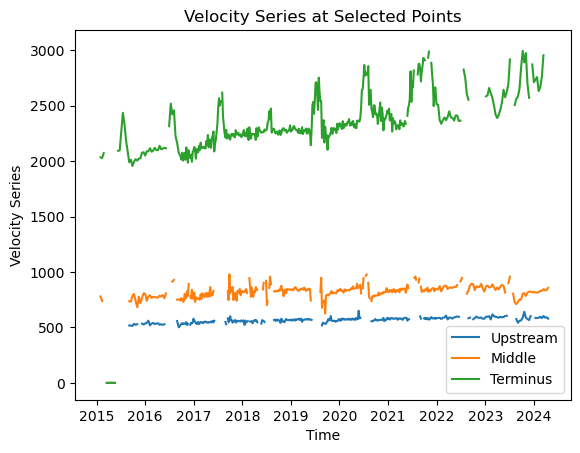

In [26]:
for x, y in zip(xpts, ypts):
    # Select the 'vv' band from the dataset
    vv_band = ziVelSeries.sel(band='vv')

    # Grab the VelocitySeries values at the specified x and y points
    selected_point = vv_band['VelocitySeries'].sel(x=x, y=y, method='nearest')

    # Convert the selected point DataArray to a pandas DataFrame
    df_selected_point = selected_point.to_dataframe().reset_index()
        
    plt.plot(df_selected_point['time'], df_selected_point['VelocitySeries'], label=f'x: {x}, y: {y}')
    
    plt.xlabel('Time')
    plt.ylabel('Velocity Series')
    plt.legend(labels)
    plt.title('Velocity Series at Selected Points')
    
    # Save the DataFrame to a CSV file with the proper label
    df_selected_point.to_csv(f'../data/raw/{label}_velocity_series_raw.csv', index=False)
    
    plt.savefig('../figures/velocity_series_raw.png', dpi=300)

## 3. Remove NaNs and zeroes from the time series
Remove NaNs and zeroes from the time series. By plotting the two together, you can see that zero values in 2015 were removed. Imputation was used to fill in missing data points. This will give an approximate value at some points but will make the dataset AI-ready.

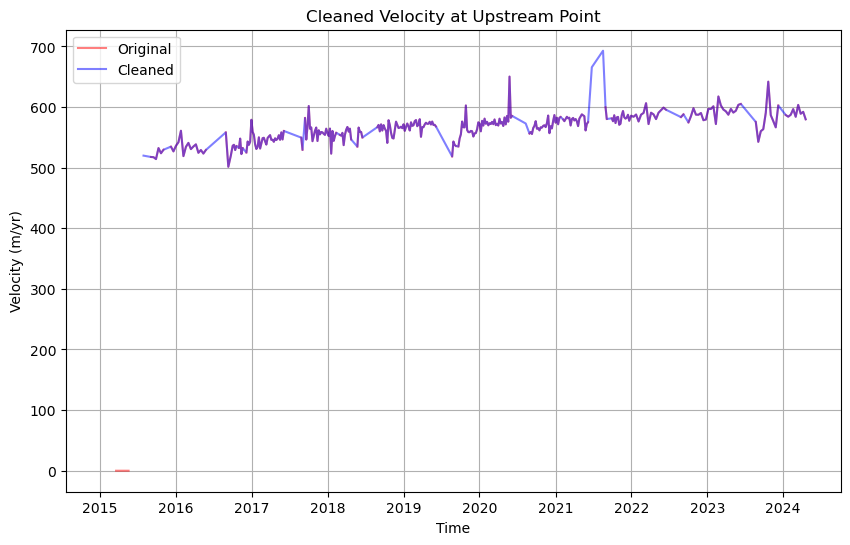

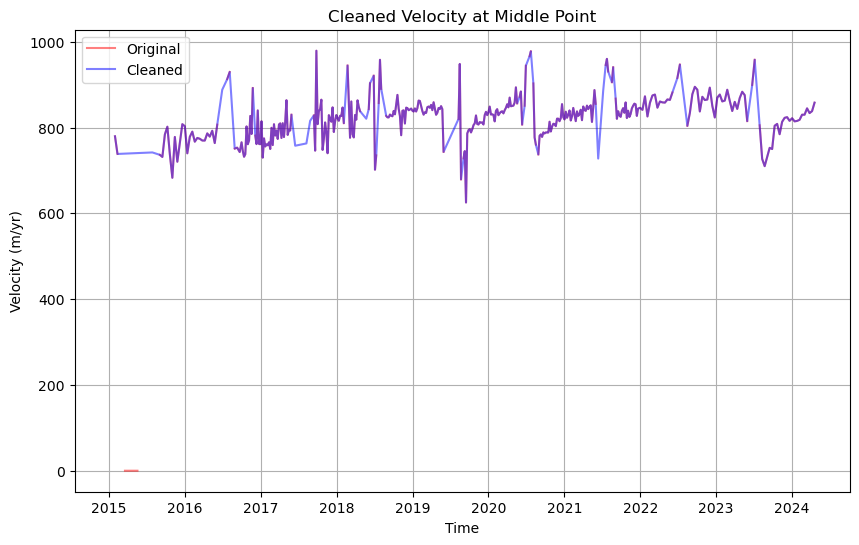

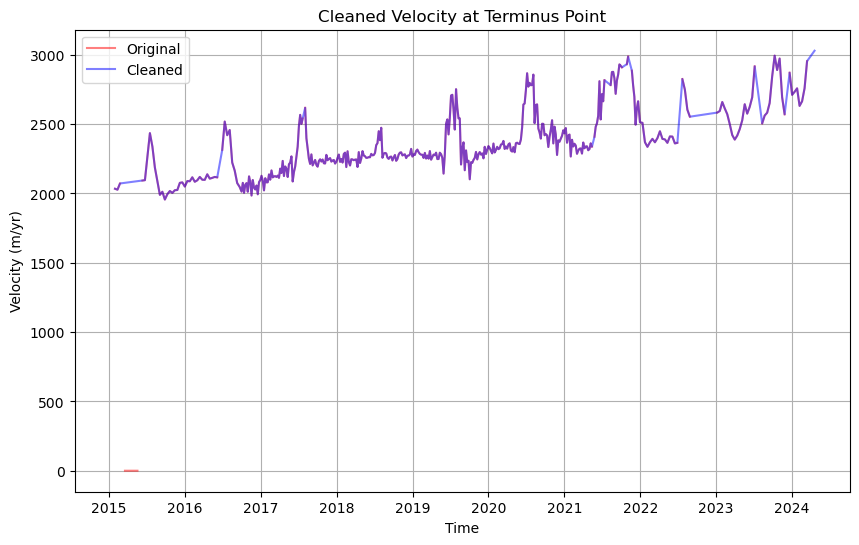

In [23]:
cleaned_velocity_series = []
cleaned_time_series = []
labels_cap = ['Upstream', 'Middle', 'Terminus']

for x, y, label in zip(xpts, ypts, labels_cap):
    # Select the 'vv' band from the dataset
    vv_band = ziVelSeries.sel(band='vv')

    # Grab the VelocitySeries values at the specified x and y points
    selected_point = vv_band['VelocitySeries'].sel(x=x, y=y, method='nearest')

    # Drop NaNs from the array and corresponding time values
    mask = ~np.isnan(selected_point) & (selected_point != 0)
    cleaned_velocity = selected_point[mask]
    cleaned_time = vv_band.time.values[mask]

    cleaned_velocity_series.append(cleaned_velocity)
    cleaned_time_series.append(cleaned_time)

    # Plot the cleaned data with the original data
    plt.figure(figsize=(10, 6))
    plt.plot(vv_band.time, selected_point, color='red', alpha=0.5, label='Original')
    plt.plot(cleaned_time, cleaned_velocity, color='blue', alpha=0.5, label='Cleaned')

    # Label the plot
    plt.xlabel('Time')
    plt.ylabel('Velocity (m/yr)')
    plt.title(f'Cleaned Velocity at {label} Point')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'../figures/cleaned_velocity_{label}.png', dpi=300)
plt.show()

In [28]:
for i, (cleaned_vel, cleaned_time) in enumerate(zip(cleaned_velocity_series, cleaned_time_series)):
    original_length = len(vv_band['VelocitySeries'][:, 0, 0])
    cleaned_length = len(cleaned_vel)
    percentage_removed = 100 - (cleaned_length / original_length * 100)
    print(f'Time series {i+1} ({labels[i]}):')
    print(f'  Original data length: {original_length}')
    print(f'  Cleaned data length: {cleaned_length}')
    print(f'  Percentage of data removed: {percentage_removed:.2f}%')

Time series 1 (Upstream):
  Original data length: 443
  Cleaned data length: 328
  Percentage of data removed: 25.96%
Time series 2 (Middle):
  Original data length: 443
  Cleaned data length: 364
  Percentage of data removed: 17.83%
Time series 3 (Terminus):
  Original data length: 443
  Cleaned data length: 405
  Percentage of data removed: 8.58%


## 4. Save to CSV

Save the cleaned data to the clean folder.

In [29]:
import pandas as pd

for i, (cleaned_vel, cleaned_time, label) in enumerate(zip(cleaned_velocity_series, cleaned_time_series, labels)):
    # Create a DataFrame from the cleaned data
    df_cleaned = pd.DataFrame({
        'time': cleaned_time,
        'VelocitySeries': cleaned_vel
    })
    
    # Save the DataFrame to a CSV file with the proper label
    df_cleaned.to_csv(f'../data/clean/{label}_velocity_series_clean.csv', index=False)